In [1]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.losses import MeanAbsolutePercentageError
from random import choice,random
import tensorflow as tf
from pprint import pformat,pprint
import keras
import pickle
from keras import layers, models, regularizers, backend, utils
import keras.backend.tensorflow_backend as tfback
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from IPython.core.display import display, HTML
from tabulate import tabulate

#widen the container width if you want
#display(HTML("<style>.container { width:90% !important; }</style>"))

K = keras.backend
mape = MeanAbsolutePercentageError()
%matplotlib inline

Using TensorFlow backend.


Check if the nvidia-docker container supplied GPU and the tf is using it:

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set up an options class. The `OPTIONS` dictionary will specify all the possibile configurations of neural networks that the genetic search algorithm can find. The `option` class will initialize as a random object, and you can create a similar `option` to `option1` by calling `option1.get_sim()`.

Read in the Sydney Data.

In [3]:
files = "Sydney Tasmania Perth Adelaide".split()

xs_tests = dict()
ys_tests = dict()
xs_trains = dict()
ys_trains = dict()
xs_lin_tests = dict()
ys_lin_tests = dict()
for file in files:
    csvfile = open(f"/notebooks/WECs_DataSet/{file}_Data.csv")    
    reader = csv.reader(csvfile, delimiter = ',')
    rows = [[float(v) for v in row] for row in reader]
    rows = np.asarray(rows, dtype='float32')
    xs = rows[:,0:32]
    ys = rows[:,32:49]
    ys = ys / np.max(ys)
    xs = xs / np.max(xs)
    xs_train, xs_test, ys_train, ys_test = train_test_split(xs,ys,test_size = 0.2)
    xs_lin_tests[file] = xs_test
    ys_lin_tests[file] = ys_test
    xs_trains[file] = xs_train
    ys_trains[file] = ys_train
    with open(f"/notebooks/models/{file}_hist.pickle","rb") as f:
        p = pickle.load(f)
    xs_tests[file]=p.validation_data[0]
    ys_tests[file]=p.validation_data[1]

Given a model, this function gets the MAPE(Mean Absolute Percentage Error) of the model using test data.

In [4]:
def get_error(file,model):
    ys_predictions = model.predict(xs_tests[file])
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    error = mape(ys_predictions, ys_tests[file]).numpy()
    return error

In [5]:
def plot_errors(file,models,pos=-1,ind=-1,s=0.19):
    if pos>0:
        plt.subplot(4,2,pos)
    maxx,minn = np.max(ys_tests[file][:,ind]),np.min(ys_tests[file][:,ind])
    for model in models:
        name = str(model.__class__).split(".")[-1][:-2]
        ys_predictions = model.predict(xs_tests[file])
        plt.scatter(ys_predictions[:,ind], ys_tests[file][:,ind], alpha = 1, s = s,label=name)
        maxx = max(np.max(ys_predictions[:,ind]),maxx)
        minn = min(np.min(ys_predictions[:,ind]),minn)
    plt.xlabel("Predicted Energy Output(normalized)")
    plt.ylabel("Actual Energy Output(normalized)")
    plt.legend()
    plt.title(f"{file} WEC #{ind}" if ind>=0 else f"{file} Total WECs Output")
    t = [minn,maxx]
    plt.axis(t+t)
    plt.plot(t,t,'r--')

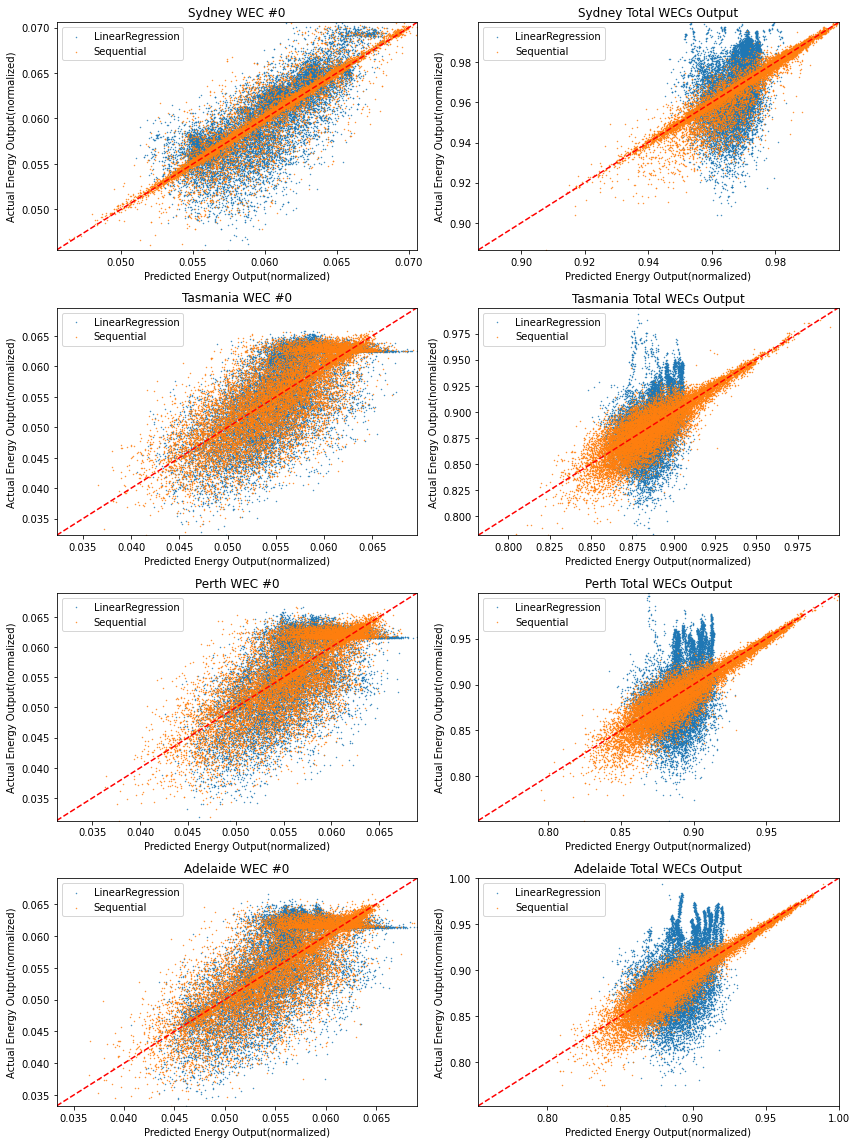

In [6]:
plt.rcParams['figure.figsize'] = [12,16]
i=0

table_data = []

for file in files:
    sequential_model = models.load_model(f'models/{file}_model.h5')
    linear_model = LinearRegression().fit(xs_trains[file],ys_trains[file])
    myModels = [linear_model,sequential_model]
    
    plot_errors(file,myModels,pos=i+1,ind=0)
    plot_errors(file,myModels,pos=i+2,ind=-1)
    
    table_data.append([file,get_error(file,linear_model),get_error(file,sequential_model)])
    
    i+=2
plt.tight_layout() 
plt.show()

Let's take a look at that last graph in detail

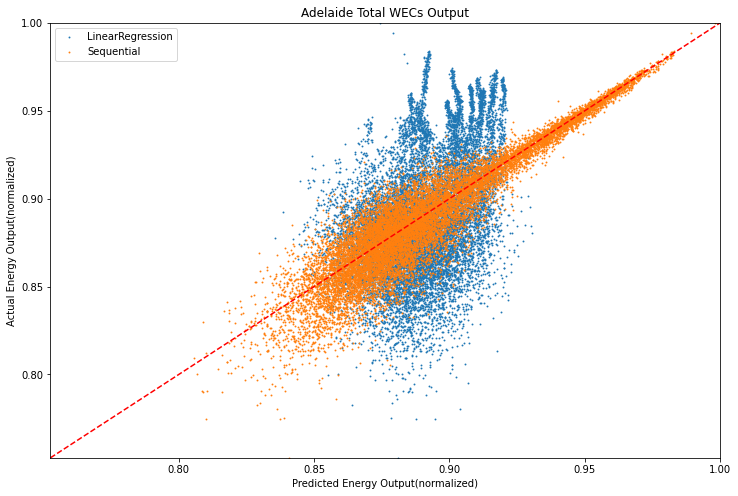

In [10]:
plt.rcParams['figure.figsize'] = [12,8]
plot_errors(file,myModels,ind=-1,s=0.8)
plt.show()

Compare the MAPE of linear regression vs the sequential network:

In [8]:
headers = "location linear sequential".split()
display(HTML("<h1>MAPE table</h1>\n"+tabulate(table_data,headers=headers,tablefmt='html')))

location,linear,sequential
Sydney,3.20286,1.2961
Tasmania,6.56439,5.39656
Perth,6.81584,5.16665
Adelaide,6.78702,4.9678


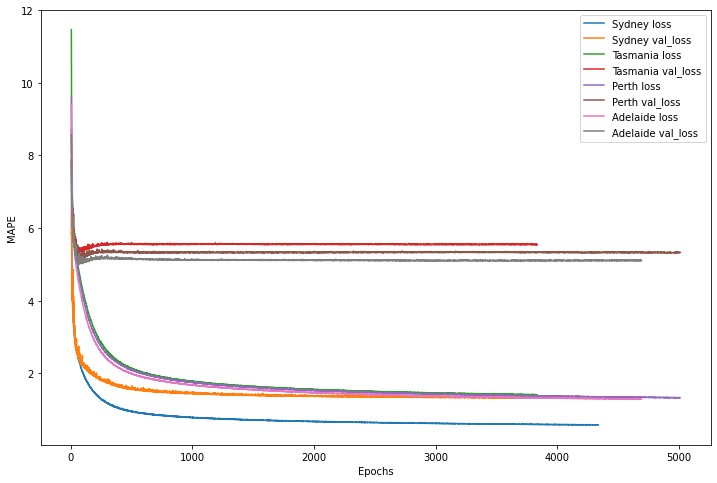

In [9]:
cutoff = 3
trains = []
for file in files:
    with open(f"/notebooks/models/{file}_hist.pickle","rb") as f:
        p = pickle.load(f)
        hist = p.history
        trains.append(p)
    
    epochs = len(hist["loss"])
    loss = np.array(hist["loss"])
    val_loss = np.array(hist["val_loss"])
    x = np.linspace(cutoff+1,epochs,epochs-cutoff)
    plt.plot(x,(loss)[cutoff:],label=f"{file} loss")
    plt.plot(x,(val_loss)[cutoff:],label=f"{file} val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MAPE")
plt.show()